In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sm_stat
import operator
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

In [56]:
def load_file(filename):
    lst = []
    with open(filename, 'r') as f:
        for line in f:
            lst.append(float(line))
    return lst

data = load_file('wacf2.txt')
print(len(data))
#Разделение на обучающую и тестовую выборку
data_train = data[:-30]
data_test = data[-30:]

100


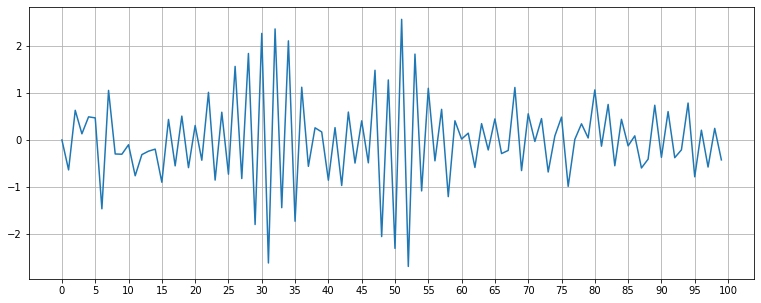

In [57]:
def show_plot(y, x_ticks):
 plt.figure(figsize=(13,5))
 plt.plot(y)
 plt.grid()
 plt.xticks(np.arange(0, len(y)+1, x_ticks))
 plt.show()
show_plot(data, 5)

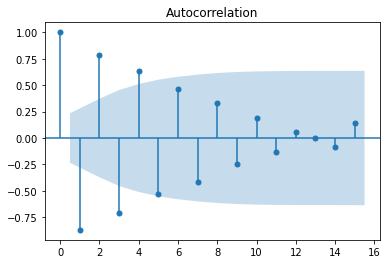

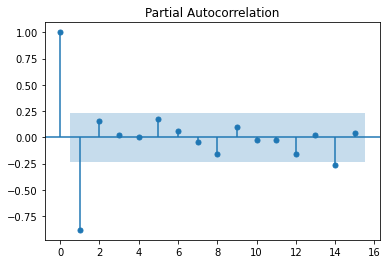

In [58]:
sm.graphics.tsa.plot_acf(data_train, lags=15) 
sm.graphics.tsa.plot_pacf(data_train, lags=15)
plt.show()

In [59]:
class ModelParams:
    def __init__(self, p=0, d=0, q=0, P=0, Q=0, D=0, s=0, tvalues=0, pvalues=0, AIC=0, BIC=0, trend=None):
        self.p = p
        self.d = d
        self.q = q
        self.P = P
        self.D = D
        self.Q = Q
        self.s = s
        self.tvalues = tvalues
        self.pvalues = pvalues
        self.AIC = AIC
        self.BIC = BIC
        self.trend = trend
        self.sum_metric = (AIC + BIC) / 2
        
model_params = []

for p in range(1+1):
    for q in range(4+1):
        for trend in ('n', 'c', 't', 'ct'):
            try:
                model = sm.tsa.ARIMA(data_train, order=(p, 0, q)).fit(full_output=True, disp=0, trend=trend)
                print(model.summary().tables[0])
                print(model.summary().tables[1])
            except:
                continue 
            mp = ModelParams(p=p, q=q, tvalues=model.tvalues, pvalues=model.pvalues, AIC=model.aic, BIC=model.bic, trend=trend)
            model_params.append(mp)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(0, 0)   Log Likelihood                -108.036
Method:                           css   S.D. of innovations              1.133
Date:                Mon, 12 Apr 2021   AIC                            220.073
Time:                        22:15:27   BIC                            224.570
Sample:                             0   HQIC                           221.859
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0271      0.135     -0.200      0.841      -0.292       0.238
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observat

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(1, 3)   Log Likelihood                 -57.995
Method:                       css-mle   S.D. of innovations              0.548
Date:                Mon, 12 Apr 2021   AIC                            127.989
Time:                        22:15:28   BIC                            141.480
Sample:                             0   HQIC                           133.348
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0233      0.041     -0.562      0.574      -0.105       0.058
ar.L1.y       -0.8717      0.076    -11.454      0.000      -1.021      -0.723
ma.L1.y        0.1554      0.137      1.138      0.2

In [60]:
nc_models_params = []
for p in range(1+1):
    for q in range(4+1):
        if p == 0 and q == 0:
            continue
        model = sm.tsa.ARIMA(data_train, order=(p, 0, q)).fit(trend='nc')
        print(model.summary().tables[0])
        print(model.summary().tables[1])
        mp = ModelParams(p=p, q=q, tvalues=model.tvalues, pvalues=model.pvalues, AIC=model.aic, BIC=model.bic)
        nc_models_params.append(mp)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(0, 1)   Log Likelihood                 -85.114
Method:                       css-mle   S.D. of innovations              0.813
Date:                Mon, 12 Apr 2021   AIC                            174.228
Time:                        22:15:36   BIC                            178.725
Sample:                             0   HQIC                           176.015
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.6342      0.068     -9.327      0.000      -0.767      -0.501
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observat

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(1, 3)   Log Likelihood                 -58.150
Method:                       css-mle   S.D. of innovations              0.550
Date:                Mon, 12 Apr 2021   AIC                            126.300
Time:                        22:15:36   BIC                            137.543
Sample:                             0   HQIC                           130.766
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.8720      0.076    -11.475      0.000      -1.021      -0.723
ma.L1.y        0.1593      0.137      1.167      0.243      -0.108       0.427
ma.L2.y        0.0933      0.129      0.723      0.4

In [61]:
sorted_model_params = sorted(nc_models_params, key=operator.attrgetter('sum_metric'))

In [62]:
fit_models = []
for m in sorted_model_params:
    if max(m.pvalues) > 0.05:
        continue 
    fit_models.append(m)
 
print("Количество скомпилированных моделей: {} \n"
 "Количество моделей только со значимыми членами: {} \n".format(len(sorted_model_params), len(fit_models)))
for  m  in  fit_models:
    print("ARIMA  ({},{},{})\n  p-values:  {}  \nAIC:  {}  BIC:  {}  Sum_metric:  {}\n".
          format( m.p,  m.d,  m.q,  m.pvalues,  m.AIC,  m.BIC,  m.sum_metric))

Количество скомпилированных моделей: 9 
Количество моделей только со значимыми членами: 4 

ARIMA  (1,0,0)
  p-values:  [3.16882266e-52]  
AIC:  122.4415350102603  BIC:  126.93852549435901  Sum_metric:  124.69003025230965

ARIMA  (0,0,4)
  p-values:  [1.19222137e-09 3.97099400e-07 5.33721205e-06 3.76536065e-05]  
AIC:  134.31474507687713  BIC:  145.55722128712392  Sum_metric:  139.93598318200054

ARIMA  (0,0,2)
  p-values:  [1.10121584e-16 1.10210400e-09]  
AIC:  148.81472784479354  BIC:  155.5602135709416  Sum_metric:  152.1874707078676

ARIMA  (0,0,1)
  p-values:  [1.08679428e-20]  
AIC:  174.22839550157212  BIC:  178.72538598567084  Sum_metric:  176.47689074362148



In [69]:
models = {}
test_table = PrettyTable()
test_table.field_names = ["Модель ARIMA", "ljungbox_stat", "p-value", "AIC", "BIC", "sum_metric"]
for m in fit_models:
    model = sm.tsa.ARIMA(data_train, order=(m.p, 0, m.q)).fit(trend='nc')
    models[f"ARIMA({m.p},0,{m.q})"] = model
    model_name = f"ARIMA({m.p},0,{m.q})"
    test_results = sm_stat.diagnostic.acorr_ljungbox(model.resid, lags=[10])
    test_table.add_row([model_name, test_results[0][0], test_results[1][0], m.AIC,  m.BIC,  m.sum_metric])
print(test_table)

+--------------+--------------------+------------------------+--------------------+--------------------+--------------------+
| Модель ARIMA |   ljungbox_stat    |        p-value         |        AIC         |        BIC         |     sum_metric     |
+--------------+--------------------+------------------------+--------------------+--------------------+--------------------+
| ARIMA(1,0,0) |  5.68736651707885  |   0.8408099153898392   | 122.4415350102603  | 126.93852549435901 | 124.69003025230965 |
| ARIMA(0,0,4) | 19.20396936225069  |  0.03774715097734098   | 134.31474507687713 | 145.55722128712392 | 139.93598318200054 |
| ARIMA(0,0,2) | 49.13190281152302  |  3.85268045366398e-07  | 148.81472784479354 | 155.5602135709416  | 152.1874707078676  |
| ARIMA(0,0,1) | 121.69918272852885 | 2.2865985073568937e-21 | 174.22839550157212 | 178.72538598567084 | 176.47689074362148 |
+--------------+--------------------+------------------------+--------------------+--------------------+--------------

In [70]:
training_data_len = len(data_train)
testing_data_len = len(data) - len(data_train) 
predicts_by_model = {}
for modelname, model in models.items():
    if modelname == 'ARIMA(0,0,4)':
        continue
    predict = model.predict(training_data_len, training_data_len + testing_data_len-1)
    predicts_by_model[modelname] = list(predict[-testing_data_len:])
    rmse.append(sqrt(mean_squared_error(data_test, predict)))
    print("RMSE {}: {}".format(modelname, np.mean(rmse)))


RMSE ARIMA(1,0,0): 0.523824531382766
RMSE ARIMA(0,0,2): 0.5236823760702313
RMSE ARIMA(0,0,1): 0.5236495376710947


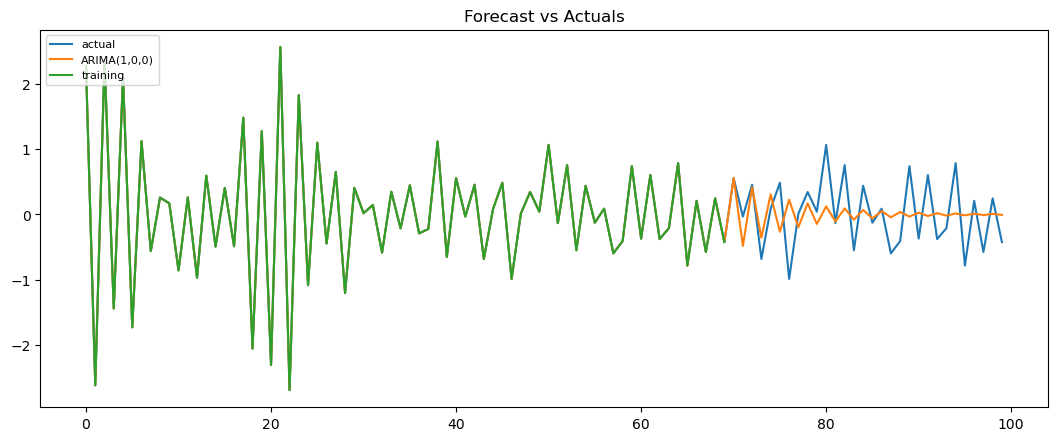

In [71]:
plt.figure(figsize=(13,5), dpi=100)
plt.plot(data[-70:] + data[-testing_data_len:], label='actual')
plt.plot(data[-70:] +predicts_by_model['ARIMA(1,0,0)'], label='ARIMA(1,0,0)')
plt.plot(data[-70:], label='training')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [10]:
rmse = []
for modelname, model in models.items():
    predict = model.predict(70,99)
    print(predict)
    print(data_test)
    rmse.append(sqrt(mean_squared_error(data_test, predict)))
    print("RMSE: {}".format(np.mean(rmse)))

[ 0.56218945 -0.48382963  0.41639186 -0.35835379  0.30840526 -0.26541872
  0.22842378 -0.19658532  0.16918461 -0.1456031   0.12530846 -0.10784256
  0.0928111  -0.07987479  0.06874158 -0.05916015  0.05091421 -0.04381762
  0.03771018 -0.03245401  0.02793046 -0.02403742  0.02068701 -0.01780358
  0.01532206 -0.01318642  0.01134845 -0.00976667  0.00840536 -0.00723379]


NameError: name 'data_test' is not defined

In [11]:
table = PrettyTable()
table.field_names = ["Модель ARIMA", "Знач[-3]", "△Знач3", "Знач[-2]", "△Знач2", "Знач[-1]", "△Знач1", "Сумма △знач"]
table.add_row(["Исходные", round(data[-3], 3), 0, round(data[-2], 3), 0, round(data[-1], 3), 0, 0])
for modelname, model in models.items():
    predict = model.predict(data_train_len, data_train_len + 2)
    predict_results = list(predict[-3:])
    table.add_row([modelname,  round(predict_results[-3], 3), round(abs(predict_results[-3] - data[-3]), 3),
              round(predict_results[-2], 3), round(abs(predict_results[-2] - data[-2]), 3),
              round(predict_results[-1], 3), round(abs(predict_results[-1] - data[-1]), 3),
              round(sum([abs(predict_results[i] - data[i]) for i in range(-3, 0)]), 3)])
print(table)

NameError: name 'data_train_len' is not defined

In [71]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

In [72]:
cross_validation = pd.DataFrame(data[:70])
test = pd.DataFrame(data[70:])
print(len(test))

30


In [ ]:
tscv = TimeSeriesSplit(n_splits = 4)
rmse = []
model_params = []
for train_index, test_index in tscv.split(cross_validation):
    cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
    arma = sm.tsa.ARIMA(cv_train, (0,0,1)).fit(disp=False)
    predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    print("RMSE: {}".format(np.mean(rmse)))